In [1]:
# draw historical crypto option figures
# run QLBS and compare with real world BS delta
import requests
import pandas as pd
import json
from datetime import datetime, timedelta
import math
import numpy as np
from scipy.stats import norm
import random
import time
import matplotlib.pyplot as plt
import sys

# Draw Historical Option Data from Deribit

In [59]:
# get price data 
def get_option_data(instrument):
        url = "/api/v2/public/get_last_trades_by_instrument_and_time"
        parameters = {"instrument_name": instrument, "end_timestamp": 1704067200000, "count": 10000}
        # send HTTPS GET request
        json_response = requests.get(("https://history.deribit.com" + url + "?"), params=parameters)
        print(json_response)
        response_dict = json.loads(json_response.content)
#         print(response_dict)
        instrument_details = response_dict["result"]['trades']
        
        
        df = pd.DataFrame(instrument_details)
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        
        return df

In [60]:
def get_put_premium(instrument, instrument_date, start_date, target_k):

    instrument_date = datetime.strptime(instrument_date, '%Y-%m-%d')
    instrument_date = instrument_date.strftime('%-d%b%y')
    
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    start_date = start_date.strftime('%-d%b%y')
    
    instrument_name = (instrument + '-' + instrument_date + '-' + str(target_k) + '-P').upper()
    print(instrument_name)
    
    data = get_option_data(instrument_name)
    data = data[data['direction'] == 'sell']
    data = data[data['timestamp'] >= start_date]
    
    return data

In [61]:
instrument = 'BTC'
instrument_date = '2022-09-30'
start_date = '2021-02-01'
target_k = 35000
data = get_put_premium(instrument, instrument_date, start_date, target_k)
data

BTC-30SEP22-35000-P
<Response [200]>


,trade_seq,trade_id,timestamp,tick_direction,price,mark_price,iv,instrument_name,index_price,direction,amount,combo_trade_id,combo_id,block_trade_id,liquidation
0,3083,230690687,2022-09-29 23:28:54.341,2,0.7960,0.794039,500.00,BTC-30SEP22-35000-P,19498.69,sell,4.0,NaN,NaN,NaN,NaN
1,3082,230632174,2022-09-29 13:05:21.159,0,0.8250,0.821081,500.00,BTC-30SEP22-35000-P,19214.11,sell,5.0,NaN,NaN,NaN,NaN
5,3078,230146612,2022-09-25 14:09:06.782,1,0.8480,0.847830,188.19,BTC-30SEP22-35000-P,18931.03,sell,0.1,NaN,NaN,NaN,NaN
6,3077,230146605,2022-09-25 14:09:02.762,0,0.8480,0.847980,166.44,BTC-30SEP22-35000-P,18929.79,sell,0.1,NaN,NaN,NaN,NaN
7,3076,228895391,2022-09-12 13:54:07.939,2,0.5640,0.564319,80.20,BTC-30SEP22-35000-P,22365.65,sell,0.1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071,12,201901038,2022-02-02 21:30:08.295,0,0.1730,0.172174,71.99,BTC-30SEP22-35000-P,37229.91,sell,0.1,NaN,NaN,NaN,NaN
3074,9,201822175,2022-02-01 23:31:47.543,2,0.1520,0.151086,71.36,BTC-30SEP22-35000-P,38832.91,sell,0.2,NaN,NaN,NaN,NaN
3078,5,201714603,2022-02-01 00:23:28.527,0,0.1575,0.157129,71.49,BTC-30SEP22-35000-P,38398.58,sell,0.1,NaN,NaN,NaN,NaN
3079,4,201680009,2022-01-31 17:15:10.842,2,0.1550,0.154443,71.28,BTC-30SEP22-35000-P,38498.87,sell,0.1,NaN,NaN,NaN,NaN


In [62]:
37236.20*0.1655

6162.5911

# Plot BS-delta on market data

In [63]:
# Define function to calculate Black-Scholes delta
def black_scholes_delta(S, K, T, r, sigma, option_type):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if option_type == 'call':
        delta = norm.cdf(d1)
    elif option_type == 'put':
        delta = norm.cdf(d1) - 1
    return delta

# Sample data (replace this with your actual DataFrame)


# Black-Scholes parameters
S0 = data['index_price']  # Current index price
K = 35000  # Strike price
maturity_date = datetime(2022, 9, 30)  # Maturity date
T = (maturity_date - data['timestamp']).dt.days / 365  # Time to maturity (in years)
r = 0.04  # Risk-free rate

# Calculate Black-Scholes delta for each row
data['delta'] = black_scholes_delta(S0, K, T, r, data['iv'].mean()/100, 'put')

# Create a new DataFrame with timestamp, index price, and delta
delta_df = data[['timestamp', 'index_price', 'delta']]

delta_df = pd.DataFrame(delta_df)
delta_df

,timestamp,index_price,delta
0,2022-09-29 23:28:54.341,19498.69,-1.000000
1,2022-09-29 13:05:21.159,19214.11,-1.000000
5,2022-09-25 14:09:06.782,18931.03,-1.000000
6,2022-09-25 14:09:02.762,18929.79,-1.000000
7,2022-09-12 13:54:07.939,22365.65,-0.997889
...,...,...,...
3071,2022-02-02 21:30:08.295,37229.91,-0.330274
3074,2022-02-01 23:31:47.543,38832.91,-0.303797
3078,2022-02-01 00:23:28.527,38398.58,-0.310725
3079,2022-01-31 17:15:10.842,38498.87,-0.308992


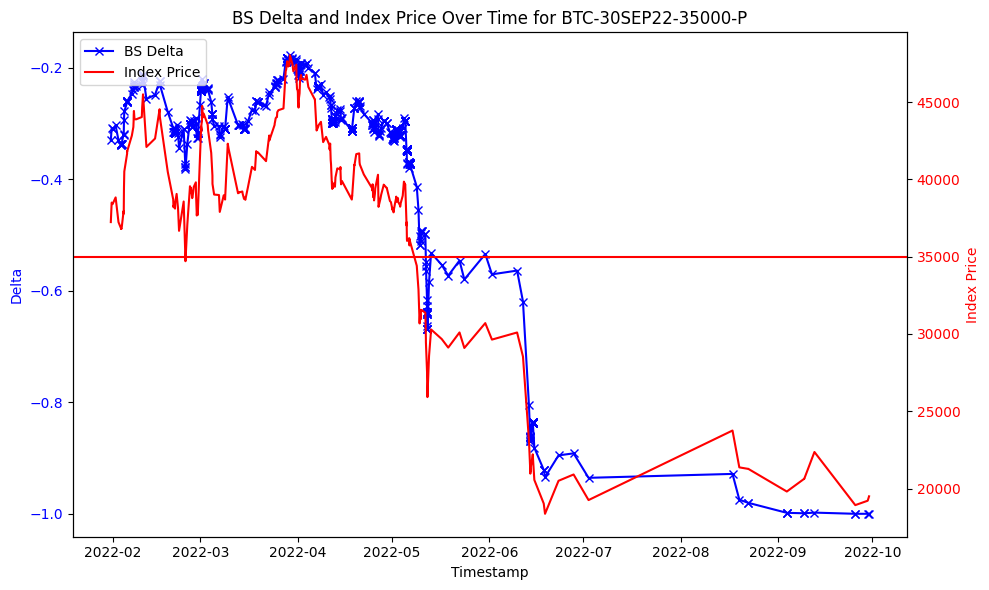

In [68]:
# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot delta values over time
ax1.plot(delta_df['timestamp'], delta_df['delta'], marker='x', linestyle='-', color='b', label='BS Delta')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Delta', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary axis for index_price
ax2 = ax1.twinx()
ax2.plot(delta_df['timestamp'], delta_df['index_price'], color='r', label='Index Price')
ax2.set_ylabel('Index Price', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add a horizontal line for the strike price
K = 35000
ax2.axhline(y=K, color='r')

# Set title and legend
plt.title('BS Delta and Index Price Over Time for BTC-30SEP22-35000-P')
fig.tight_layout()

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.show()

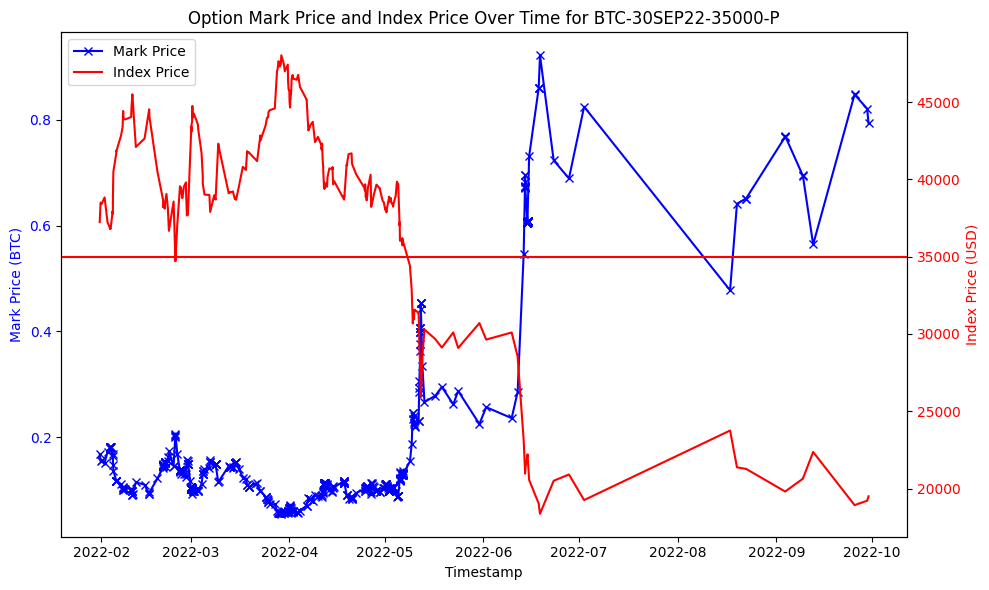

In [71]:
# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot mark price values over time instead of BS Delta
ax1.plot(delta_df['timestamp'], data['mark_price'], marker='x', linestyle='-', color='b', label='Mark Price')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Mark Price (BTC)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary axis for index_price
ax2 = ax1.twinx()
ax2.plot(delta_df['timestamp'], delta_df['index_price'], color='r', label='Index Price')
ax2.set_ylabel('Index Price (USD)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add a horizontal line for the strike price
K = 35000
ax2.axhline(y=K, color='r')

# Set title and legend
plt.title('Option Mark Price and Index Price Over Time for BTC-30SEP22-35000-P')
fig.tight_layout()

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.show()


# QLBS on historical dataset

In [7]:
delta_df.set_index('timestamp', inplace=True)
df_resampled = delta_df.resample('D').mean()

In [8]:
# get drift and volatilty estimates of BTC price
index_price = df_resampled['index_price']
# Calculate logarithmic returns
returns = np.log(index_price / index_price.shift(1))

# Estimate drift (average daily return)
average_drift = returns.mean()

# Estimate volatility (standard deviation of daily returns)
volatility = returns.std()

#alt vol
volatility = data['iv'].mean()/100

print("Average Drift:", average_drift)
print("Volatility:", volatility)

Average Drift: -0.0009645207013500616
Volatility: 0.7035785335689045


In [9]:
S0 = data['index_price'].iloc[-1] 
# S0 = data['index_price'].iloc[0]  # initial stock price
mu = average_drift   # drift
# sigma = volatility*6  # volatility
sigma = volatility  # volatility
r = 0.04      # risk-free rate
M = 2/3        # maturity

T = 24        # number of time steps
N_MC = 10000  # number of paths

delta_t = M / T                # time interval
gamma = np.exp(- r * delta_t)  # discount factor

In [10]:
starttime = time.time()
np.random.seed(42)

# stock price
S = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1), dtype=float)
S.loc[:,0] = S0 # starting price of price path

# standard normal random numbers
RN = pd.DataFrame(np.random.randn(N_MC,T), index=range(1, N_MC+1), columns=range(1, T+1)) # row*col -> sample paths

# generate stock prices evolving from a geometric brownian motion
for t in range(1, T+1):
    S.loc[:,t] = S.loc[:,t-1] * np.exp((mu - 1/2 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN.loc[:,t])

# get stock returns for each time step
delta_S = S.loc[:,1:T].values - np.exp(r * delta_t) * S.loc[:,0:T-1]
delta_S_hat = delta_S.apply(lambda x: x - np.mean(x), axis=0) # difference in return from the mean

# state variable
X = - (mu - 1/2 * sigma**2) * np.arange(T+1) * delta_t + np.log(S)   # delta_t here is due to their conventions

endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')


Time Cost: 0.050733089447021484 seconds


In [11]:
# Define the minimum and maximum values
min_value = math.ceil(S.min().min())  # Round up to the nearest integer
max_value = math.floor(S.max().max())  # Round down to the nearest integer

# Create an array with values incremented by 500 from min to max, including both min and max
spot_delta = np.arange(min_value, max_value + 1, 500)

# Print the values array
print("Values array:", spot_delta)

Values array: [  3443   3943   4443   4943   5443   5943   6443   6943   7443   7943
   8443   8943   9443   9943  10443  10943  11443  11943  12443  12943
  13443  13943  14443  14943  15443  15943  16443  16943  17443  17943
  18443  18943  19443  19943  20443  20943  21443  21943  22443  22943
  23443  23943  24443  24943  25443  25943  26443  26943  27443  27943
  28443  28943  29443  29943  30443  30943  31443  31943  32443  32943
  33443  33943  34443  34943  35443  35943  36443  36943  37443  37943
  38443  38943  39443  39943  40443  40943  41443  41943  42443  42943
  43443  43943  44443  44943  45443  45943  46443  46943  47443  47943
  48443  48943  49443  49943  50443  50943  51443  51943  52443  52943
  53443  53943  54443  54943  55443  55943  56443  56943  57443  57943
  58443  58943  59443  59943  60443  60943  61443  61943  62443  62943
  63443  63943  64443  64943  65443  65943  66443  66943  67443  67943
  68443  68943  69443  69943  70443  70943  71443  71943  72443

In [12]:
X.values.shape

(10000, 25)

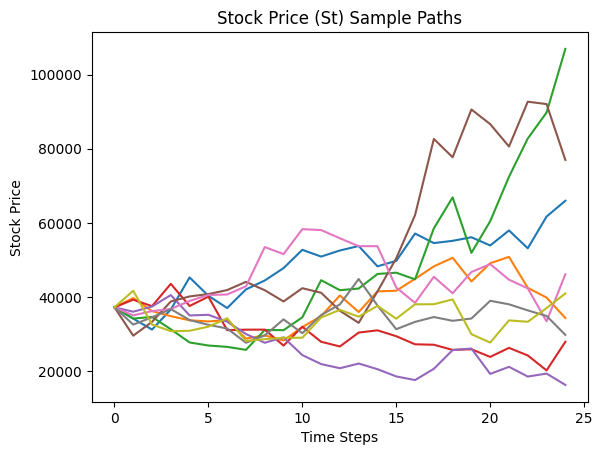

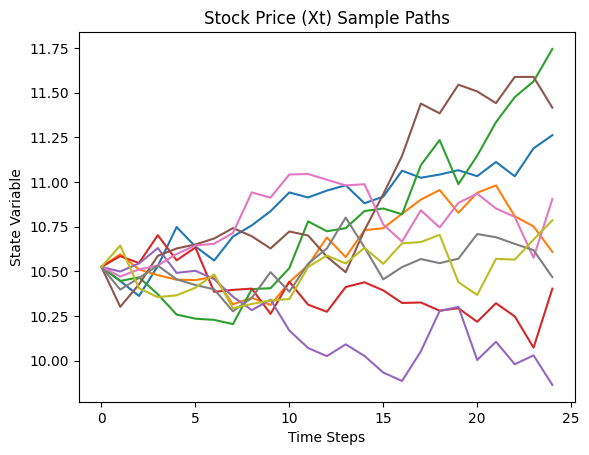

In [13]:
# plot 10 stock paths of GBM 
step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size) # selected paths

# St
plt.plot(S.T.iloc[:,idx_plot])
plt.ylabel('Stock Price')
plt.xlabel('Time Steps')
plt.title('Stock Price (St) Sample Paths')
plt.show()

# Xt
plt.plot(X.T.iloc[:,idx_plot])
plt.title('Stock Price (Xt) Sample Paths')
plt.xlabel('Time Steps')
plt.ylabel('State Variable')
plt.show()

In [14]:
def terminal_payoff(ST, K):
    # ST   final stock price
    # K    strike
    payoff = max(K - ST, 0)
    return payoff

## Basis functions

X.shape =  (10000, 25)
X_min, X_max =  8.302810084271437 12.767890294600184
Number of points k =  17


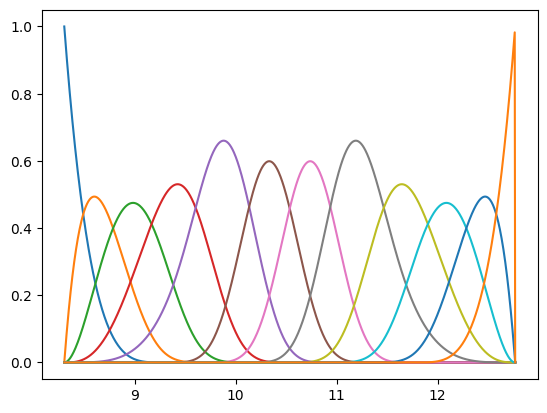

In [15]:
import bspline
import bspline.splinelab as splinelab

X_min = np.min(np.min(X))
X_max = np.max(np.max(X))
print('X.shape = ', X.shape)
print('X_min, X_max = ', X_min, X_max)

p = 4              # order of spline (3: cubic, 4: B-spline)
ncolloc = 12  # points where the solution of the equation or the approximation of the function satisfy the equation at those points.

tau = np.linspace(X_min,X_max,ncolloc)  # These are the sites to which we would like to interpolate

# k is a knot vector that adds endpoints repeats as appropriate for a spline of order p
# To get meaninful results, one should have ncolloc >= p+1
k = splinelab.aptknt(tau, p) 
                             
# Spline basis of order p on knots k
basis = bspline.Bspline(k, p)        
        
f = plt.figure()
# B   = bspline.Bspline(k, p)     # Spline basis functions 
print('Number of points k = ', len(k))
basis.plot()

# plt.savefig('Basis_functions.png', dpi=600)

In [16]:
num_t_steps = T + 1
num_basis =  ncolloc 

data_mat_t = np.zeros((num_t_steps, N_MC, num_basis ))
print('num_basis = ', num_basis)
print('dim data_mat_t = ', data_mat_t.shape)

t_0 = time.time()
# fill it 
for i in np.arange(num_t_steps):
    x = X.values[:,i]
    data_mat_t[i,:,:] = np.array([ basis(el) for el in x ]) # apply data points onto bspline

t_end = time.time()
print('Computational time:', t_end - t_0, 'seconds')

num_basis =  12
dim data_mat_t =  (25, 10000, 12)
Computational time: 25.32250213623047 seconds


In [17]:
print(data_mat_t.shape)  # shape num_steps x N_MC x num_basis
print(len(k))

(25, 10000, 12)
17


In [18]:
risk_lambda = 0.001

In [19]:
# functions to compute optimal hedges
def function_A_vec(t, delta_S_hat, data_mat, reg_param):
    """
    function_A_vec - compute the matrix A_{nm} from Eq. (52) (with a regularization!)
    Eq. (52) in QLBS Q-Learner in the Black-Scholes-Merton article
    
    Arguments:
    t - time index, a scalar, an index into time axis of data_mat
    delta_S_hat - pandas.DataFrame of dimension N_MC x T
    data_mat - pandas.DataFrame of dimension T x N_MC x num_basis
    reg_param - a scalar, regularization parameter
    
    Return:
    - np.array, i.e. matrix A_{nm} of dimension num_basis x num_basis
    """

    X_mat = data_mat[t, :, :]
    num_basis_funcs = X_mat.shape[1]
    this_dS = delta_S_hat.loc[:, t]
    hat_dS2 = (this_dS ** 2).to_numpy().reshape(-1, 1) # flatten delta S df
    A_mat = np.dot(X_mat.T, X_mat * hat_dS2) + reg_param * np.eye(num_basis_funcs)

    return A_mat
   
        
def function_B_vec(t, 
                   Pi_hat, 
                   delta_S_hat=delta_S_hat, 
                   S=S, 
                   data_mat=data_mat_t,
                   gamma=gamma,
                   risk_lambda=risk_lambda):
    """
    function_B_vec - compute vector B_{n} from Eq. (52) QLBS Q-Learner in the Black-Scholes-Merton article
    
    Arguments:
    t - time index, a scalar, an index into time axis of delta_S_hat
    Pi_hat - pandas.DataFrame of dimension N_MC x T of portfolio values 
    delta_S_hat - pandas.DataFrame of dimension N_MC x T
    S - pandas.DataFrame of simulated stock prices of dimension N_MC x T
    data_mat - pandas.DataFrame of dimension T x N_MC x num_basis
    gamma - one time-step discount factor $exp(-r \delta t)$
    risk_lambda - risk aversion coefficient, a small positive number
    Return:
    np.array() of dimension num_basis x 1
    """

#     coef = 1.0/(2 * gamma * risk_lambda)
#     tmp = Pi_hat.loc[:,t+1] * delta_S_hat.loc[:, t] + coef * delta_S_hat.loc[:, t]

    # override it by zero to have pure risk hedge
    
    tmp = Pi_hat.loc[:,t+1] * delta_S_hat.loc[:, t]

    X_mat = data_mat[t, :, :]  # matrix of dimension N_MC x num_basis
    B_vec = np.dot(X_mat.T, tmp)

    return B_vec

In [20]:
starttime = time.time()

# portfolio value
Pi = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi.iloc[:,-1] = S.iloc[:,-1].apply(lambda x: terminal_payoff(x, K))

Pi_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_hat.iloc[:,-1] = Pi.iloc[:,-1] - np.mean(Pi.iloc[:,-1])

# optimal hedge
a = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a.iloc[:,-1] = 0

reg_param = 1e-3 # free parameter
for t in range(T-1, -1, -1):
    A_mat = function_A_vec(t, delta_S_hat, data_mat_t, reg_param)
    B_vec = function_B_vec(t, Pi_hat, delta_S_hat, S, data_mat_t, gamma, risk_lambda)
#     print ('t =  A_mat.shape = B_vec.shape = ', t, A_mat.shape, B_vec.shape)
    
    # coefficients for expansions of the optimal action
    phi = np.dot(np.linalg.inv(A_mat), B_vec)
    
    a.loc[:,t] = np.dot(data_mat_t[t,:,:],phi)
    Pi.loc[:,t] = gamma * (Pi.loc[:,t+1] - a.loc[:,t] * delta_S.loc[:,t])
    Pi_hat.loc[:,t] = Pi.loc[:,t] - np.mean(Pi.loc[:,t])
    
a = a.astype('float')
Pi = Pi.astype('float')
Pi_hat = Pi_hat.astype('float')

endtime = time.time()
print('Computational time:', endtime - starttime, 'seconds')

Computational time: 0.469696044921875 seconds


In [21]:
a

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
1,-0.292734,-0.272768,-0.303973,-0.272838,-0.179454,-0.161158,-0.191443,-0.131503,-0.029859,-0.075387,...,-0.444057,-0.540076,-0.690678,-0.695826,-0.829900,-1.016127,-0.871871,-0.988749,-1.108326,0.0
2,-0.292734,-0.348098,-0.347367,-0.412196,-0.437861,-0.488699,-0.529075,-0.665521,-0.457653,-0.479060,...,-0.969133,-0.872891,-0.748794,-0.875331,-0.882183,-1.145035,-0.914838,-1.652346,-0.706062,0.0
3,-0.292734,-0.281609,-0.414323,-0.406824,-0.458654,-0.496524,-0.480356,-0.418960,-0.343377,-0.428521,...,-0.611942,-0.712566,-0.704731,-0.553056,-0.576980,-0.432995,-0.396123,-0.553353,-0.472902,0.0
4,-0.292734,-0.305811,-0.221257,-0.406734,-0.359502,-0.385512,-0.387582,-0.405506,-0.571971,-0.712472,...,-0.667124,-0.647693,-0.726800,-0.729197,-0.737284,-0.642535,-0.750900,-0.945325,-1.067932,0.0
5,-0.292734,-0.284422,-0.292525,-0.312277,-0.308090,-0.458685,-0.476984,-0.569417,-0.587339,-0.739680,...,-0.711826,-0.700411,-0.737517,-0.434965,-0.482706,-0.472127,-0.500364,-0.841430,-0.565544,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,-0.292734,-0.336976,-0.485140,-0.401146,-0.266229,-0.211702,-0.237455,-0.196717,-0.101194,-0.060968,...,-0.557647,-0.266969,-0.315545,-0.346043,-0.344098,-0.258242,-0.323738,-0.003361,0.047349,0.0
9997,-0.292734,-0.337112,-0.456363,-0.410493,-0.508898,-0.413278,-0.542968,-0.595652,-0.438263,-0.297224,...,-0.346104,-0.262471,-0.091900,-0.141735,-0.090530,-0.272930,-0.095863,-0.213102,-0.072902,0.0
9998,-0.292734,-0.291173,-0.306632,-0.176195,-0.187874,-0.114793,-0.073338,-0.120086,-0.035277,-0.099060,...,-0.285584,-0.370017,-0.414118,-0.285145,-0.163836,-0.640806,-0.807882,-0.988922,-1.100139,0.0
9999,-0.292734,-0.238694,-0.301616,-0.244296,-0.272723,-0.453126,-0.390615,-0.340380,-0.337170,-0.356541,...,-0.294147,-0.154374,-0.351237,-0.469386,-0.623185,-0.736050,-0.772391,-0.737611,-0.625854,0.0


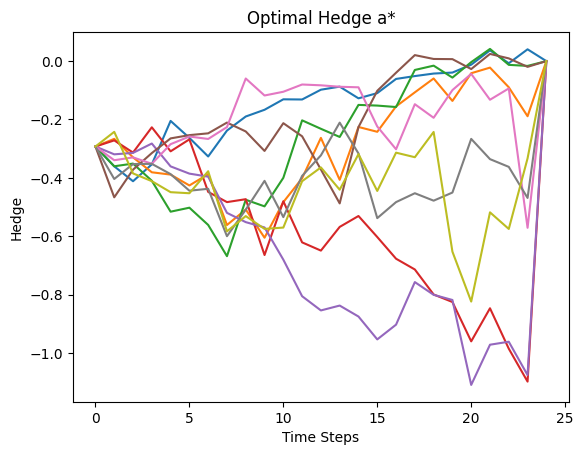

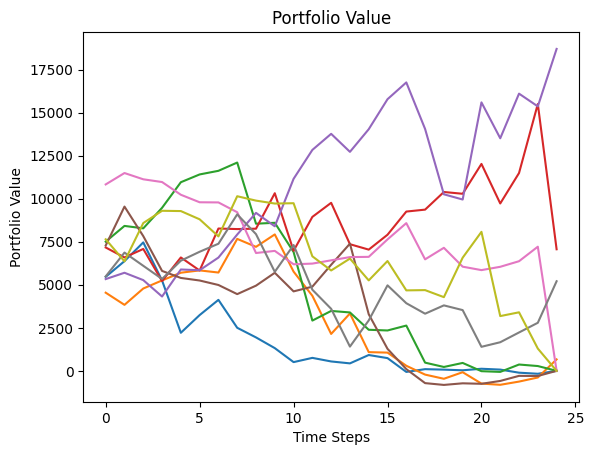

In [22]:
# plot 10 paths
plt.plot(a.T.iloc[:,idx_plot])
plt.xlabel('Time Steps')
plt.ylabel('Hedge')
plt.title('Optimal Hedge a*')
plt.show()

plt.plot(Pi.T.iloc[:,idx_plot])
plt.xlabel('Time Steps')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value')
plt.show()

In [23]:
btc_index = delta_df['index_price']

In [24]:
a.shape

(10000, 25)

In [25]:
a_t = a.iloc[:, :-1]
S_t = S.iloc[:, :-1]

## Delta curve

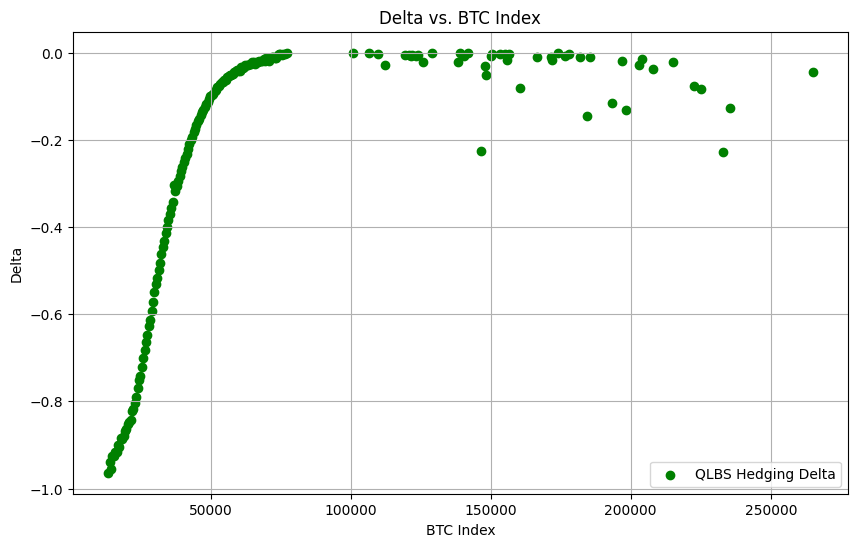

In [42]:
#QLBS Delta

flattened_a = a_t.values.flatten()
flattened_S = S_t.values.flatten()

# Assuming flattened_S and flattened_a are 1D arrays
data = {'flattened_S': flattened_S, 'flattened_a': flattened_a}

# Create DataFrame
delta_curve = pd.DataFrame(data)
delta_curve = delta_curve.sort_values(by='flattened_S')

# Group the sorted DataFrame by values within 500 of each other and calculate the mean
grouped_mean = delta_curve.groupby(pd.cut(delta_curve['flattened_S'], bins=range(int(delta_curve['flattened_S'].min()), int(delta_curve['flattened_S'].max()) + 500, 500)))['flattened_a'].mean()

average_hedges = []

# Convert the grouped_mean Series to a DataFrame
grouped_mean_df = grouped_mean.reset_index()

grouped_mean_df = grouped_mean_df.iloc[20:-14]
grouped_mean_df = grouped_mean_df[grouped_mean_df['flattened_a'] <= 0]


# Display the DataFrame with mean values
# print(grouped_mean_df)
# x_values = grouped_mean_df['flattened_S'].apply(lambda x: x.left)
grouped_mean_df['flattened_S'] = grouped_mean_df['flattened_S'].apply(lambda x: x.left)
grouped_mean_df['flattened_S'] = grouped_mean_df['flattened_S'].astype(int)
# grouped_mean_df = grouped_mean_df[grouped_mean_df['flattened_S'] <= 100000]

# Extract the mean values
y_values = grouped_mean_df['flattened_a']

plt.figure(figsize=(10, 6))
plt.scatter(grouped_mean_df['flattened_S'], y_values, marker='o', color='g', label='QLBS Hedging Delta')
plt.xlabel('BTC Index')
plt.ylabel('Delta')
plt.title('Delta vs. BTC Index')
plt.grid(True)
plt.legend()
plt.show()


In [43]:
#BS Delta
def black_scholes_delta(S, K, r, sigma, T, t, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * ((T - t)/T)) / (sigma * np.sqrt(T - t))
    if option_type == 'call':
        delta = norm.cdf(d1)
    elif option_type == 'put':
        delta = norm.cdf(d1) - 1
    return delta

T = 24 
t_values = np.arange(1, T+1)  # time steps

# Create DataFrame to store Black-Scholes deltas for put option
black_scholes_deltas_put = pd.DataFrame(index=range(1, N_MC+1), columns=t_values, dtype=float)

# Calculate Black-Scholes delta for each time step for each stock path for put option
for t in t_values:
    black_scholes_deltas_put[t] = black_scholes_delta(S.iloc[:, t], K, r, sigma, T, t, option_type='put')
    
# flattened_S = S_t.values.flatten()    
flattened_bs_a = black_scholes_deltas_put.values.flatten()

# Assuming flattened_S and flattened_a are 1D arrays
data_bs = {'flattened_S': flattened_S, 'flattened_bs_a': flattened_bs_a}

# Create DataFrame
delta_curve_bs = pd.DataFrame(data_bs)
delta_curve_bs = delta_curve_bs.sort_values(by='flattened_S')

# Group the sorted DataFrame by values within 500 of each other and calculate the mean
grouped_mean_bs = delta_curve_bs.groupby(pd.cut(delta_curve_bs['flattened_S'], bins=range(int(delta_curve_bs['flattened_S'].min()), int(delta_curve_bs['flattened_S'].max()) + 500, 500)))['flattened_bs_a'].mean()

average_bs_hedges = []

# Convert the grouped_mean Series to a DataFrame
grouped_mean_bs_df = grouped_mean_bs.reset_index()

# print(grouped_mean_bs_df)

# grouped_mean_bs_df = grouped_mean_bs_df.iloc[11:-8]

# Display the DataFrame with mean values
# print(grouped_mean_df)
x_values_bs = grouped_mean_bs_df['flattened_S'].apply(lambda x: x.left)

# Extract the mean values
y_values_bs = grouped_mean_bs_df['flattened_bs_a']

grouped_mean_bs_df['flattened_S'] = x_values_bs

# grouped_mean_bs_df


In [44]:
# grouped_mean_df

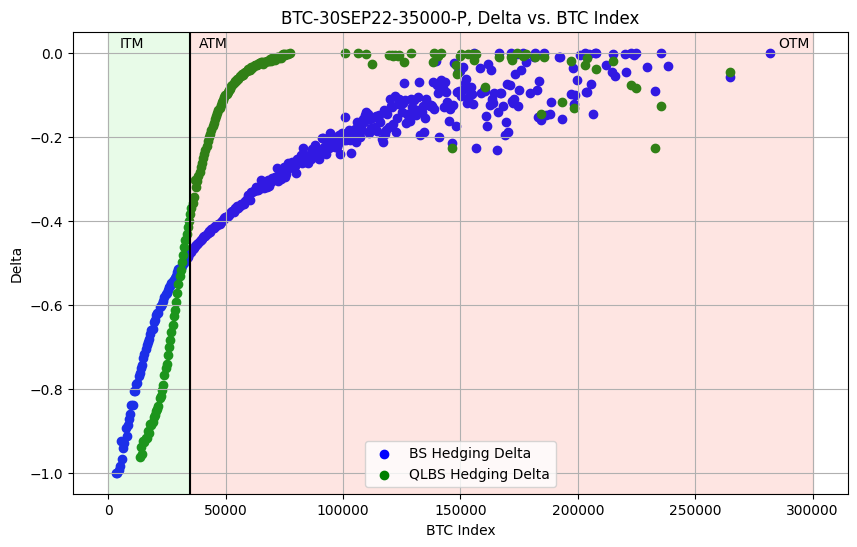

In [128]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the first pair of scatter plots
ax.scatter(x_values_bs, y_values_bs, marker='o', color='b', label='BS Hedging Delta')

# Plot the second pair of scatter plots on the same axis
ax.scatter(grouped_mean_df['flattened_S'], y_values, marker='o', color='g', label='QLBS Hedging Delta')

# Set labels and title
ax.set_xlabel('BTC Index')
ax.set_ylabel('Delta')
ax.set_title('BTC-30SEP22-35000-P, Delta vs. BTC Index')

# Add a vertical line at 35000 in black
ax.axvline(x=35000, color='k')

# # Add text annotations for OTM and ITM at top left and top right corners respectively
ax.text(0.06, 0.99, 'ITM', ha='left', va='top', transform=ax.transAxes)
ax.text(0.95, 0.99, 'OTM', ha='right', va='top', transform=ax.transAxes)
ax.text(0.20, 0.99, 'ATM', ha='right', va='top', transform=ax.transAxes)

# Shade the region to the left of the line with sky blue (OTM)
ax.axvspan(0, 35000, color='lightgreen', alpha=0.2)

# Shade the region to the right of the line with salmon pink (ITM)
ax.axvspan(35000, 300000, color='salmon', alpha=0.2)

# Show legend
ax.legend()

# Show the plot
plt.grid(True)
plt.show()


## Deltas from QLBS for historical market data

In [46]:
# Create an empty array to store closest flattened_a values
closest_flattened_a = np.empty(len(btc_index))

# Iterate through each index in btc_index
for i, index in enumerate(btc_index):
    # Find the index of the row in grouped_mean_df with the closest flattened_S value
    closest_index = np.abs(grouped_mean_df['flattened_S'] - index).argmin()
    
    # Get the corresponding flattened_a value and assign it to the array
    closest_flattened_a[i] = grouped_mean_df.iloc[closest_index]['flattened_a']

closest_flattened_a

array([-0.8680855 , -0.8680855 , -0.87978402, ..., -0.29447005,
       -0.29447005, -0.31862048])

In [47]:
# grouped_mean_df['flattened_S'] = x_values
# grouped_mean_df['flattened_S']=grouped_mean_df['flattened_S'].astype(float)

# # Iterate through each index in btc_index
# for index in btc_index:
#     # Find the index of the row in grouped_mean_df with the closest flattened_S value
#     closest_index = np.abs(grouped_mean_df['flattened_S'] - index).argmin()
    
#     # Get the corresponding flattened_a value
#     closest_flattened_a.append(grouped_mean_df.iloc[closest_index]['flattened_a'])

# # Convert the list to a numpy array
# closest_flattened_a = np.array(closest_flattened_a)
# closest_flattened_a

In [48]:
# Create a new DataFrame
historical_df = pd.DataFrame({'index_price':btc_index, 'closest_flattened_a': closest_flattened_a}, index=btc_index.index)
historical_df

,index_price,closest_flattened_a
timestamp,,
2022-09-29 23:28:54.341,19498.69,-0.868085
2022-09-29 13:05:21.159,19214.11,-0.868085
2022-09-25 14:09:06.782,18931.03,-0.879784
2022-09-25 14:09:02.762,18929.79,-0.879784
2022-09-12 13:54:07.939,22365.65,-0.816433
...,...,...
2022-02-02 21:30:08.295,37229.91,-0.318620
2022-02-01 23:31:47.543,38832.91,-0.283028
2022-02-01 00:23:28.527,38398.58,-0.294470


In [49]:
# remove outliers from divergence
historical_df.loc[historical_df['closest_flattened_a'] > 0, 'closest_flattened_a'] = -0.4

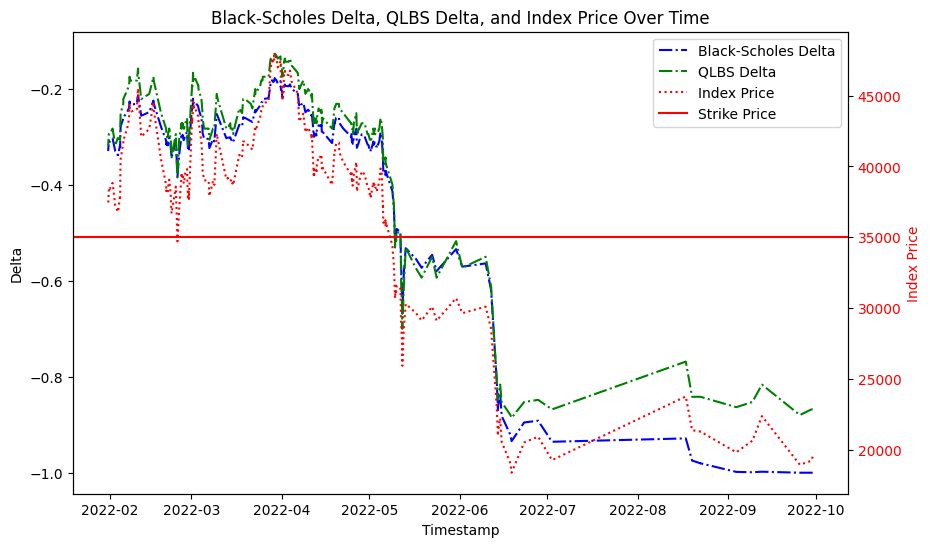

In [50]:
# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Black-Scholes Delta over time
ax1.plot(delta_df.index, delta_df['delta'], linestyle='-.', color='b', label='Black-Scholes Delta')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Delta')
ax1.tick_params(axis='y')

# Plot closest_flattened_a over time on the same axis (ax1)
ax1.plot(historical_df.index, historical_df['closest_flattened_a'], linestyle='-.', color='g', label='QLBS Delta')

# Create a secondary axis for index_price
ax2 = ax1.twinx()
ax2.plot(delta_df.index, delta_df['index_price'], color='r', linestyle='dotted', label='Index Price')
ax2.set_ylabel('Index Price', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add a horizontal line for the strike price on ax2
K = 35000
ax2.axhline(y=K, color='r', label='Strike Price')

# Set title
plt.title('Black-Scholes Delta, QLBS Delta, and Index Price Over Time')

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Show plot
plt.show()


## QLBS put price


Time Cost: 0.06511211395263672 seconds


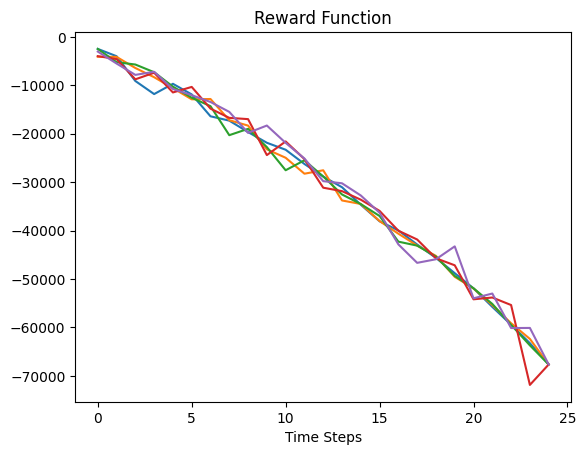

In [52]:
# Compute rewards for all paths
starttime = time.time()
# reward function
R = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
R.iloc[:,-1] = - risk_lambda * np.var(Pi.iloc[:,-1])

for t in range(T):
    R.loc[1:,t] = gamma * a.loc[1:,t] * delta_S.loc[1:,t] - risk_lambda * np.var(Pi.loc[1:,t])

endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')
  
# plot 5 paths
plt.plot(R.T.iloc[:, idx_plot[:5]])
plt.xlabel('Time Steps')
plt.title('Reward Function')
plt.show()

In [53]:
def function_C_vec(t, data_mat, reg_param):
    """
    function_C_vec - calculate C_{nm} matrix from Eq. (56) (with a regularization!)
    Eq. (56) in QLBS Q-Learner in the Black-Scholes-Merton article
    
    Arguments:
    t - time index, a scalar, an index into time axis of data_mat 
    data_mat - pandas.DataFrame of values of basis functions of dimension T x N_MC x num_basis
    reg_param - regularization parameter, a scalar
    
    Return:
    C_mat - np.array of dimension num_basis x num_basis
    """

    X_mat = data_mat[t, :, :]
    num_basis_funcs = X_mat.shape[1]
    C_mat = np.dot(X_mat.T, X_mat) + reg_param * np.eye(num_basis_funcs)

    return C_mat
   
def function_D_vec(t, Q, R, data_mat, gamma=gamma):
    """
    function_D_vec - calculate D_{nm} vector from Eq. (56) (with a regularization!)
    Eq. (56) in QLBS Q-Learner in the Black-Scholes-Merton article
    
    Arguments:
    t - time index, a scalar, an index into time axis of data_mat 
    Q - pandas.DataFrame of Q-function values of dimension N_MC x T
    R - pandas.DataFrame of rewards of dimension N_MC x T
    data_mat - pandas.DataFrame of values of basis functions of dimension T x N_MC x num_basis
    gamma - one time-step discount factor $exp(-r \delta t)$
    
    Return:
    D_vec - np.array of dimension num_basis x 1
    """
    

    X_mat = data_mat[t, :, :]
    D_vec = np.dot(X_mat.T, R.loc[:,t] + gamma * Q.loc[:, t+1])

    return D_vec


Time Cost: 0.33782100677490234 seconds


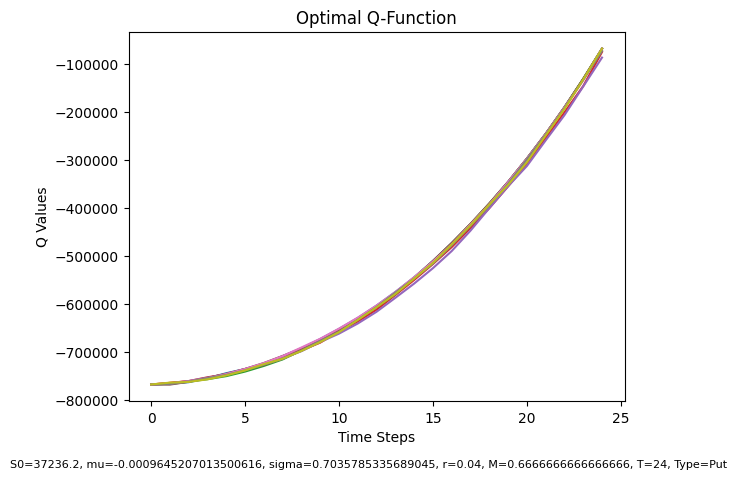

In [54]:
starttime = time.time()

# Q function
Q = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q.iloc[:,-1] = - Pi.iloc[:,-1] - risk_lambda * np.var(Pi.iloc[:,-1])

reg_param = 1e-3
for t in range(T-1, -1, -1):
    ######################
    C_mat = function_C_vec(t,data_mat_t,reg_param)
    D_vec = function_D_vec(t, Q,R,data_mat_t,gamma)
    omega = np.dot(np.linalg.inv(C_mat), D_vec)
    
    Q.loc[:,t] = np.dot(data_mat_t[t,:,:], omega)
    
Q = Q.astype('float')
endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')


# plot 10 paths
plt.plot(Q.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.ylabel('Q Values')
plt.title('Optimal Q-Function')
plt.suptitle('S0={}, mu={}, sigma={}, r={}, M={}, T={}, Type=Put'.format(S0, mu, sigma, r, M, T), fontsize=8, y=-0.01)
plt.show()

In [55]:
# The Black-Scholes prices
# BS equations
def bs_put(t, S0=S0, K=K, r=r, sigma=sigma, T=M):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = K * np.exp(-r * (T-t)) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return price

def bs_call(t, S0=S0, K=K, r=r, sigma=sigma, T=M):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = S0 * norm.cdf(d1) - K * np.exp(-r * (T-t)) * norm.cdf(d2)
    return price



In [ ]:
# QLBS option price
C_QLBS = - Q.copy()

print('-------------------------------------------')
print('       QLBS Option Pricing (DP solution)      ')
print('-------------------------------------------\n')
print('%-25s' % ('Initial Stock Price:'), S0)
print('%-25s' % ('Drift of Stock:'), mu)
print('%-25s' % ('Volatility of Stock:'), sigma)
print('%-25s' % ('Risk-free Rate:'), r)
print('%-25s' % ('Risk aversion parameter: '), risk_lambda)
print('%-25s' % ('Strike:'), K)
print('%-25s' % ('Maturity:'), M)
print('%-26s %.4f' % ('\nQLBS Put Price: ', C_QLBS.iloc[0,0]))
print('%-26s %.4f' % ('\nBlack-Sholes Put Price:', bs_put(0)))
print('\n')

# plot 10 paths
plt.plot(C_QLBS.T.iloc[:,idx_plot])
plt.xlabel('Time Steps')
plt.ylabel('Put Price')
plt.title('QLBS Option Price')
plt.suptitle('S0={}, mu={}, sigma={}, r={}, M={}, T={}, Type=Put'.format(S0, mu, sigma, r, M, T), fontsize=8, y=-0.01)
plt.show()